CS575 Applied Time Series Analysis - Mini Project (April 2021)

Submitted by - 2121CS07, Nelson Sharma

In [ ]:
%reset

In [ ]:
pip install statsmodels==0.12.2

     |████████████████████████████████| 9.5MB 7.6MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# [] IMPORTS []

In [ ]:
import datetime
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.simplefilter('ignore', ConvergenceWarning)


# [] GLOBAL []

In [ ]:
# global variables

# Resampled every signal to this rate for consistency
BASIC_SRATE = 128 #Hz
print('Basic sampling rate(Hz):',BASIC_SRATE)

MODEL_DIR = '/content/drive/MyDrive/cs575_mini_project/model'
print('MODEL DIR ::',MODEL_DIR)

DATASET_DIR = '/content/drive/MyDrive/cs575_mini_project/dataset'
print('DATASET DIR ::',DATASET_DIR)

DATASET_DIR_NPY = '/content/drive/MyDrive/cs575_mini_project/db_npy'
print('DATASET_NPY DIR ::',DATASET_DIR_NPY)

# std annotation 
std_annotations = os.path.join(DATASET_DIR,'ANTS.txt')
print('STD ANN FILE ::',std_annotations)

# >------ load standard labels ------------------------------------------
std_ant = np.loadtxt(std_annotations, dtype='str',delimiter="\t")
# <------ load standard labels ------------------------------------------

#-----------------------------------------------------------------------------
# Seperate out stand beat and non-beat annotations using 'annotations.txt'
beat_ants = []
non_beat_ants = []
print('\nStandard Labels::')
for a in std_ant:
    # a[0] =  # standard label (char)
    # a[1] =  # type of label
    # a[2]  = # description (str)
    print(a[0]+'\t'+a[1]+'\t'+a[2])
    if a[1]=='b': #<<--- is a beat-annotation
        beat_ants.append(a[0])
    else:
        non_beat_ants.append(a[0])

print('')
print('beat-annotation:',len(beat_ants))
print('non-beat-annotation:',len(non_beat_ants))
#-----------------------------------------------------------------------------

#-----------------------------------------------------------------------------
# data file identifiers 
g_BEAT = '_BEAT.npy'         #<<--- beat annotations
g_NBEAT = '_NBEAT.npy'       #<<--- non-beat annotations
g_SIG2 = '_SIG_II.npy'     #<<--- Signal Data (Removed manual gain)
#-----------------------------------------------------------------------------
# define a mapping dictionary
custom_ants = [ '_N','_S','_V','_F','_Q']
custom_cols = { '_N':'tab:green',
               '_S':'tab:red',
               '_V':'tab:blue',
               '_F':'tab:purple',
               '_Q':'tab:pink'}
custom_mapping = {
                    'N': '_N',
                    'L': '_N',
                    'R': '_N',
                    'B': '_N',
                    'A': '_S',
                    'a': '_S',
                    'J': '_S',
                    'S': '_S',
                    'V': '_V',
                    'r': '_V',
                    'F': '_F',
                    'e': '_N',
                    'j': '_N',
                    'n': '_N',
                    'E': '_N',
                    'f': '_Q',
                    '/': '_Q',
                    'Q': '_Q',
                    '?': '_Q',
                }

Basic sampling rate(Hz): 128
MODEL DIR :: /content/drive/MyDrive/cs575_mini_project/model
DATASET DIR :: /content/drive/MyDrive/cs575_mini_project/dataset
DATASET_NPY DIR :: /content/drive/MyDrive/cs575_mini_project/db_npy
STD ANN FILE :: /content/drive/MyDrive/cs575_mini_project/dataset/ANTS.txt

Standard Labels::
N	b	Normal beat
L	b	Left bundle branch block beat
R	b	Right bundle branch block beat
B	b	Bundle branch block beat (unspecified)
A	b	Atrial premature beat
a	b	Aberrated atrial premature beat
J	b	Nodal (junctional) premature beat
S	b	Supraventricular premature or ectopic beat (atrial or nodal)
V	b	Premature ventricular contraction
r	b	R-on-T premature ventricular contraction
F	b	Fusion of ventricular and normal beat
e	b	Atrial escape beat
j	b	Nodal (junctional) escape beat
n	b	Supraventricular escape beat (atrial or nodal)
E	b	Ventricular escape beat
/	b	Paced beat
f	b	Fusion of paced and normal beat
Q	b	Unclassifiable 
?	b	Beat not classified during learning
[	n	Start of vent

# [] CLASS DEFS []

In [ ]:
#REC_MINt, REC_MAXt = 0, 1800
#REC_MINs, REC_MAXs = REC_MINt*BASIC_SRATE, REC_MAXt*BASIC_SRATE
class ecgDatabase:
    def __init__(self, db_name, db_path):
        self.db_name = db_name
        self.db_path = db_path
        self._prepare()
        
    def _prepare(self):
        self.record_list = np.loadtxt(os.path.join(self.db_path,'RECORDS'), dtype='str',delimiter="\n")
        # prepare a dictionary of ecgRecord objects
        self.records = {}
        for irec in self.record_list:
            self.records[irec] = ecgRecord(irec,os.path.join(self.db_path))
        #print('Prepared', len(self.records.keys()), 'records')
        return
        
    def get_record(self, rec_name):
        if rec_name in self.records.keys():
            this_rec = self.records[rec_name]
            if not this_rec.isloaded:
                this_rec.loadfromdisk()
            return this_rec
        else:
            return None
        
class ecgRecord:
    def __init__(self, arg_recname, arg_path):
        self.path = arg_path
        self.name = arg_recname
        self.isloaded = False
        

    def loadfromdisk(self):
        #print('\nLoading Record:', self.name)
        
        #<<---------------------------------------------
        # Load Signal Data
        #<<---------------------------------------------
        self.signal_file = os.path.join(self.path,self.name + g_SIG2)
        self.iSignal = np.load(self.signal_file)
        #print('Signal Length =',self.iSignal.shape)
        #print('Signal Duration =',len(self.iSignal)/BASIC_SRATE, 'sec')
        
        #<<---------------------------------------------
        # Load Beat-Annotation (Labels)
        #<<---------------------------------------------
        self.beat_file = os.path.join(self.path,self.name + g_BEAT)
        self.iBeat = np.load(self.beat_file)
        #print('beats:',self.iBeat.shape)
        # seperate out R-peaks and Labels (note both are in string format)
        self.iRpeaks = self.iBeat[:,0].astype('int') #<<-- convert sampling locations to integer
        self.iLabels = self.iBeat[:,1]               #<<-- labels remain as string
        self.nos_beats = len(self.iRpeaks)
        #<<---------------------------------------------
        # Load Non-Beat-Annotation
        #<<---------------------------------------------
        #nbeat_file = os.path.join(idbPath,iRecord + g_NBEAT)
        #iNbeat = np.load(nbeat_file)
        #print('non-beats:',iNbeat.shape)
        # seperate out R-peaks and non-beats (note both are in string format)
        #inRpeaks = iNbeat[:,0].astype('int') #<<-- convert sampling locations to integer
        #inLabels = iNbeat[:,1] #<<-- labels remain as string
        #<<---------------------------------------------
        # assign object vars
        #<<---------------------------------------------

        self.isloaded = True
        return self.isloaded

    # for mapping custom labels   ** rec.mLabels = rec.map_beat_labels(custom_mapping)
    def map_beat_labels(self, aami_mapping):
        iLabels = np.zeros(len(self.iLabels), dtype='U2')       
        for i in range(0,len(self.iLabels)):
            iLabels[i]=aami_mapping[self.iLabels[i]]
        return iLabels

    def get_beats_indices_of_label(self, self_label_list, lable_to_find):
        #return np.where(((self.iRpeaks >= pf) & (self.iRpeaks < pt) & (self_label_list==lable_to_find)))[0]
        return np.where( (self_label_list==lable_to_find) )[0]
        
    def get_signal_slice_fd(self,pf, pt):
        signal_slice = self.iSignal[pf:pt]
        signal_list = np.where((self.iRpeaks>=pf) & (self.iRpeaks<pt))[0]
        return signal_slice, signal_list

    def get_signal_slice_rri(self, Rpeaki, minus_i, plus_i ,signal_pad_left, signal_pad_right ):
        RpeakL = self.iRpeaks[Rpeaki-minus_i]+signal_pad_left
        RpeakC = self.iRpeaks[Rpeaki]
        RpeakR = self.iRpeaks[Rpeaki+plus_i]-signal_pad_right
        pf,pt = RpeakL,RpeakR
        signal_slice=self.iSignal[pf:pt]
        signal_list = np.where((self.iRpeaks>=pf) & (self.iRpeaks<pt))[0]
        return signal_slice, signal_list, pf, pt

#-------------------------------------------------------------------------------------------------------------------
#    def get_signal_slice_ap(self, Rpeak, left_samples, right_samples ):
#        signal_slice = self.iSignal[Rpeak-left_samples:Rpeak+right_samples]
#        Rpeaki = np.where(self.iRpeaks==Rpeak)[0][0]
#        return signal_slice, Rpeaki
    def get_signal_slice_api(self, Rpeaki, left_samples, right_samples ):
        Rpeak = self.iRpeaks[Rpeaki]
        signal_slice = self.iSignal[Rpeak-left_samples:Rpeak+right_samples]
        return signal_slice, Rpeaki
#-------------------------------------------------------------------------------------------------------------------

# [] VIEW []

In [ ]:
# functions for plotting
yll, yul, ycl = -3, 3.5, -2.8

def plot_beat(rec, bindex, mi, pi, spl, spr,w=0.012, h=4, r=0.5):
    signal_slice, slist, pf, pt = rec.get_signal_slice_rri(bindex,mi,pi,spl,spr)
    plt.figure(figsize=(w*len(signal_slice),h), constrained_layout=True)
    plt.ylim(yll, yul)
    plt.xlim(pf,pt)
    if r>0:
        _range=np.arange(pf,pt,BASIC_SRATE*r)
        plt.xticks(_range,np.round(_range/BASIC_SRATE,2),rotation=60)#plt.xticks(_range,)
        plt.grid(axis='x')
    
    plt.plot(np.arange(pf,pt,1 ), signal_slice, color='black',linewidth=0.8)
    plt.vlines(rec.iRpeaks[bindex],yll,yul,linestyle='dotted',color= custom_cols[rec.mLabels[bindex]] )
    plt.title(rec.iLabels[bindex])
    
    plt.show()
    return signal_slice, slist, pf, pt 

def plot_api(rec, Rpeaki, lsamp, rsamp, show_label_ticks=False, show_custom_labels=True, show_custom_vline=False, w=0.012, h=4):
    # get signal data and lanels
    Rpeak = rec.iRpeaks[Rpeaki]
    plot_from,plot_to = Rpeak-lsamp, Rpeak+rsamp
    return plot_fixed(rec, 
               plot_from, plot_to, mul_BSR=False,
               show_label_ticks=show_label_ticks, 
               show_custom_labels=show_custom_labels, 
               show_custom_vline=show_custom_vline, 
               w=w, h=h)
    #return rec.iRpeaks[Rpeaki], rec.iLabels[Rpeaki]
    
def plot_fixed(rec, pf, pt, mul_BSR=True, show_label_ticks=False, show_custom_labels=True, show_custom_vline=False, w=0.012, h=4):
    # get signal data and lanels
    if mul_BSR:
        pf, pt = int(pf*BASIC_SRATE), int(pt*BASIC_SRATE)

    signal_slice, i_list = rec.get_signal_slice_fd(pf, pt)
    ilen = len(i_list)
    _range = np.arange(pf,pt,BASIC_SRATE)
    _peaks = rec.iRpeaks[i_list]
    _labels = rec.iLabels[i_list]
    _colorL = rec.mColors[i_list]
    #if len(signal_slice)!= (pt-pf):
    #    print(signal_slice.shape, pt-pf, '<----------mismatch')
    
    plt.figure(figsize=(w*len(signal_slice),h), constrained_layout=True)
    plt.ylim(yll, yul)
    plt.xlim(pf,pt)
    plt.plot(np.arange(pf,pt,1 ), signal_slice, color='black',linewidth=0.8)
    #plt.xlabel('Time(sec)')
    if show_label_ticks:
        plt.xticks(_peaks,_labels) #-pf*BASIC_SRATE
        plt.grid( axis='x')
    else:
        plt.xticks(_range,np.round(_range/BASIC_SRATE,2))#,rotation=60)
        #plt.grid( axis='x')

    if show_custom_labels:
        plt.scatter(_peaks ,np.zeros(ilen)+ycl, c=_colorL)
        if show_custom_vline:
            for j in range(0,ilen):
                plt.vlines(_peaks[j],yll,yul,linewidth=0.4,color=_colorL[j])

    
    plt.show()
    return signal_slice, i_list

## Select Database

In [ ]:
db = 'db_01' # Select  from ['mitdb', 'svdb', 'incartdb']
dbo = ecgDatabase(db, os.path.join(DATASET_DIR, db))
print(dbo.db_name,'@',dbo.db_path)
print(dbo.record_list.shape,dbo.record_list)

db_01 @ /content/drive/MyDrive/cs575_mini_project/dataset/db_01
(10,) ['116' '214' '215' '223' '233' 'I37' 'I38' 'I46' 'I48' 'I52']


## Select Record

In [ ]:
recn = '116'#np.random.choice(dbo.record_list) #'200'
rec = dbo.get_record(recn)
print(rec.path, rec.name, '\t'+str(rec.nos_beats)+ ' beats\n')
rec.mLabels = rec.map_beat_labels(custom_mapping)

caDict={}
sum = 0
for ca in  custom_ants:
    caDict[ca] = rec.get_beats_indices_of_label(rec.mLabels,ca)
    isum = len(caDict[ca])
    sum+=isum
    print(ca,'\t\t',isum)
print('__','\t\t',sum)

# PRE-PROCESS DATA   **NOTE:: SKIPPING FIRST AND LAST BEAT OF THE RECORD

# calulate delta rri
rp_p, rp_c, rp_n = rec.iRpeaks[0:-2], rec.iRpeaks[1:-1], rec.iRpeaks[2:]
rp_prev = (rp_c-rp_p)
rp_next = (rp_n-rp_c) 
rp_delta = rp_next - rp_prev
rp_delta_abs = np.abs(rp_delta)
rp_avg = (rp_next + rp_prev)/2
rpL = len(rp_avg)
rec.mColors = np.zeros(rpL,dtype='U10')
for i in range(0, rpL):
    rec.mColors[i] = custom_cols[rec.mLabels[i]]
# find true Normal Rhythm beats
mLabels_p,mLabels_c,mLabels_n = rec.mLabels[0:-2],rec.mLabels[1:-1],rec.mLabels[2:]

# Any Normal: All Normal beats
NR_any = np.where((mLabels_c=='_N'))[0]+1

# True Normal: Normal surronded by normal on both sides
NR_true = np.where((mLabels_p=='_N') & (mLabels_c=='_N') & (mLabels_n=='_N'))[0]+1

# Semi Normal: Normal surronded by normal on both sides
NR_semi = np.where((mLabels_c=='_N') & ((mLabels_p!='_N') | (mLabels_n!='_N')))[0]+1

# Absolute Normal: True Normal and |rri_prev-rri_next| < ABS_DELTA_DUR
ABS_DELTA_DUR = 0.04
NR_abs = np.where((mLabels_p=='_N') & (mLabels_c=='_N') & (mLabels_n=='_N')
                  & (rp_delta_abs<=ABS_DELTA_DUR))[0] + 1

# Abnormal beats
NA_list = np.where((mLabels_c!='_N'))[0] + 1
NAS_list =np.where((mLabels_c=='_S'))[0] + 1
NAV_list =np.where((mLabels_c=='_V'))[0] + 1
NAF_list =np.where((mLabels_c=='_F'))[0] + 1
NAQ_list =np.where((mLabels_c=='_Q'))[0] + 1

print("\nNormals\t\t", len(NR_any))
print(" True-type\t", len(NR_true))
print(" Semi-type\t", len(NR_semi))
print(" Abs-type\t", len(NR_abs))

print("\nAbnormals\t", len(NA_list))
print(" S-Type\t\t", len(NAS_list))
print(" V-Type\t\t", len(NAV_list))
print(" F-Type\t\t", len(NAF_list))
print(" Q-type\t\t", len(NAQ_list))

print("\nTotal\t\t",len(rp_avg)) # len(NA_list)+len(NR_any) - len(rp_avg) == 0 should hold

/content/drive/MyDrive/cs575_mini_project/dataset/db_01 116 	2412 beats

_N 		 2302
_S 		 1
_V 		 109
_F 		 0
_Q 		 0
__ 		 2412

Normals		 2300
 True-type	 2085
 Semi-type	 215
 Abs-type	 293

Abnormals	 110
 S-Type		 1
 V-Type		 109
 F-Type		 0
 Q-type		 0

Total		 2410


## Locate Peaks

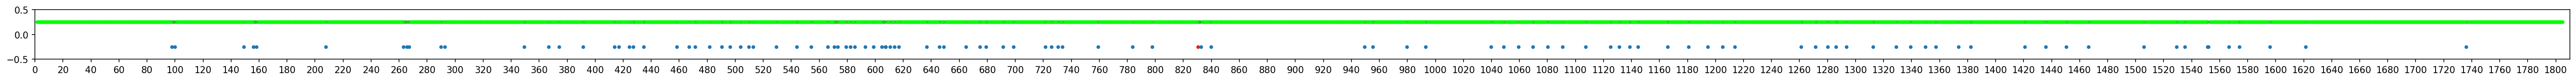

In [ ]:
NR_MEGA =       [ NR_semi, NR_true] #'NR_any,'  NR_abs
NR_MEGA_COL =   [(0.1,0.8,0.1), (0.0,1.0,0.0)]
NA_MEGA = [NAS_list, NAV_list, NAF_list, NAQ_list ]
NA_MEGA_COL = ['tab:red', 'tab:blue', 'tab:purple', 'tab:gray']

plt.figure(figsize=(50,1), dpi=150)
plt.xlim(0, 1810)
plt.xticks(np.arange(0, 1810, 20))
plt.ylim(-.5,.5)
for iNL in range(0, len(NR_MEGA)):
    NL = NR_MEGA[iNL]
    J = rec.iRpeaks[NL]/BASIC_SRATE
    K = np.zeros(len(J))+0.25
    #plt.xticks(np.linspace(0,np.max(J),num=25))
    plt.scatter(J,K,marker='.', color=NR_MEGA_COL[iNL])
for iNL in range(0, len(NA_MEGA)):
    NL = NA_MEGA[iNL]
    J = rec.iRpeaks[NL]/BASIC_SRATE
    K = np.zeros(len(J))-0.25
    #plt.xticks(np.linspace(0,np.max(J),num=25))
    plt.scatter(J,K,marker='.', color=NA_MEGA_COL[iNL])
plt.show()


### Select Peak

In [ ]:
psf = 605
pst = psf + 10
print(psf,',',pst)

605 , 615


## Plot Record

### __> Time vs Volt

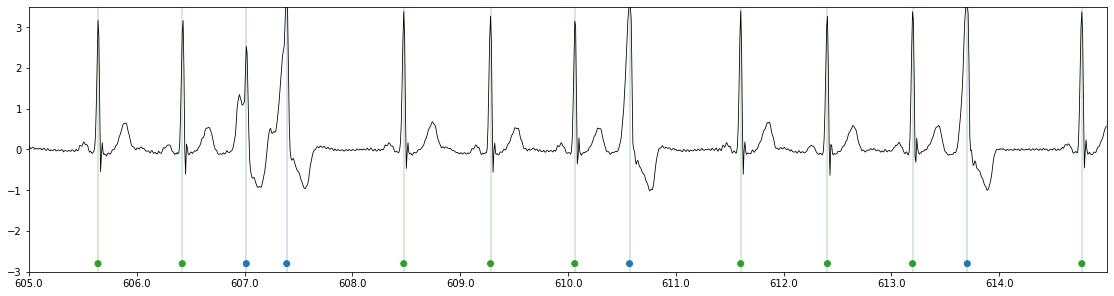

[804 805 806 807 808 809 810 811 812 813 814 815 816]


In [ ]:
_,_bl,= plot_fixed(rec,psf,pst,show_label_ticks=False, show_custom_labels=True, show_custom_vline=True)
print(_bl)

### __> Label vs Volt

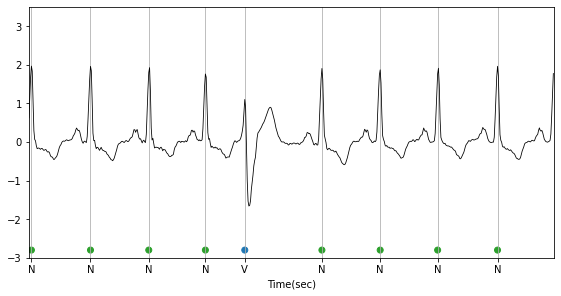

In [ ]:
_=plot_fixed(rec,psf,pst,show_label_ticks=True, show_custom_labels=True, show_custom_vline=False)

## RR-Intervals

#beats: 2410


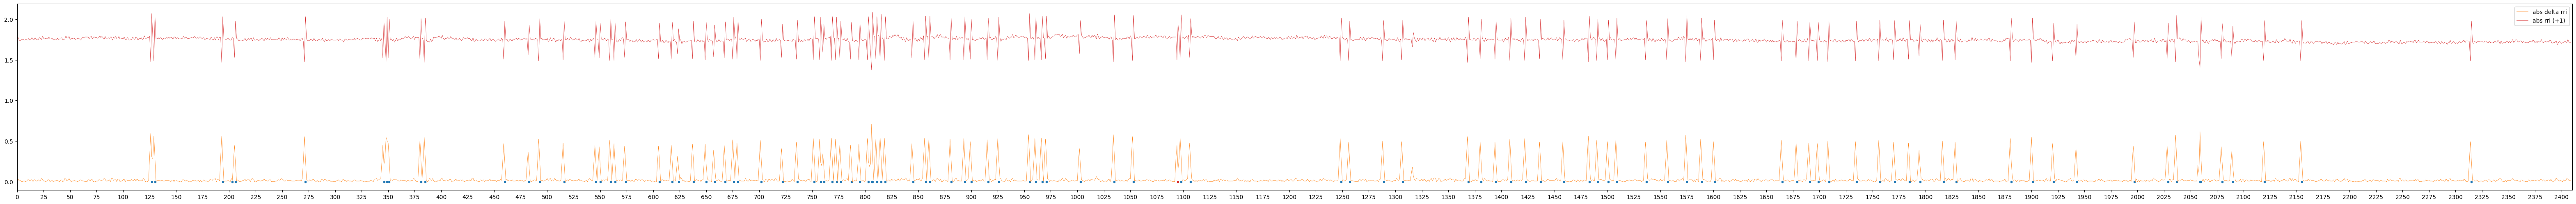

In [ ]:

print('#beats:',rpL)
rp_ARRAY = [rp_delta_abs,rp_prev] #[rp_delta_abs,rp_delta,rp_prev,rp_next,rp_avg]
rp_ARRAY_COL = ['tab:orange','tab:red'] #['tab:orange','tab:red','tab:blue', 'tab:purple','black'  ]
rp_ARRAY_LAB = ['abs delta rri', 'abs rri (+1)'] #['abs delta rri','delta rri','prev rri', 'next rri','avg rri'  ]
#fig,ax = plt.subplots(len(rp_ARRAY),1,sharex=True, figsize=(18,6), dpi=150)
plt.figure(figsize=(rpL/30,6), dpi=100)
plt.xlim((0,rpL))
plt.xticks(np.arange(0,rpL,25))
#ax[i].set_ylim((x,x))
plt.plot(rp_ARRAY[0]/BASIC_SRATE, linewidth=0.5, color=rp_ARRAY_COL[0], label=rp_ARRAY_LAB[0])
plt.plot(rp_ARRAY[1]/BASIC_SRATE + 1, linewidth=0.5, color=rp_ARRAY_COL[1], label=rp_ARRAY_LAB[1])
plt.scatter(NAS_list,np.zeros(len(NAS_list)),color=custom_cols['_S'],marker='.') #marker=matplotlib.markers.TICKUP )
plt.scatter(NAV_list,np.zeros(len(NAV_list)),color=custom_cols['_V'],marker='.') #marker=matplotlib.markers.TICKUP )
plt.scatter(NAF_list,np.zeros(len(NAF_list)),color=custom_cols['_F'],marker='.') #marker=matplotlib.markers.TICKUP )
plt.scatter(NAQ_list,np.zeros(len(NAQ_list)),color=custom_cols['_Q'],marker='.') #marker=matplotlib.markers.TICKUP )
plt.legend()
plt.show()

## Heart-Rate

#beats: 2410


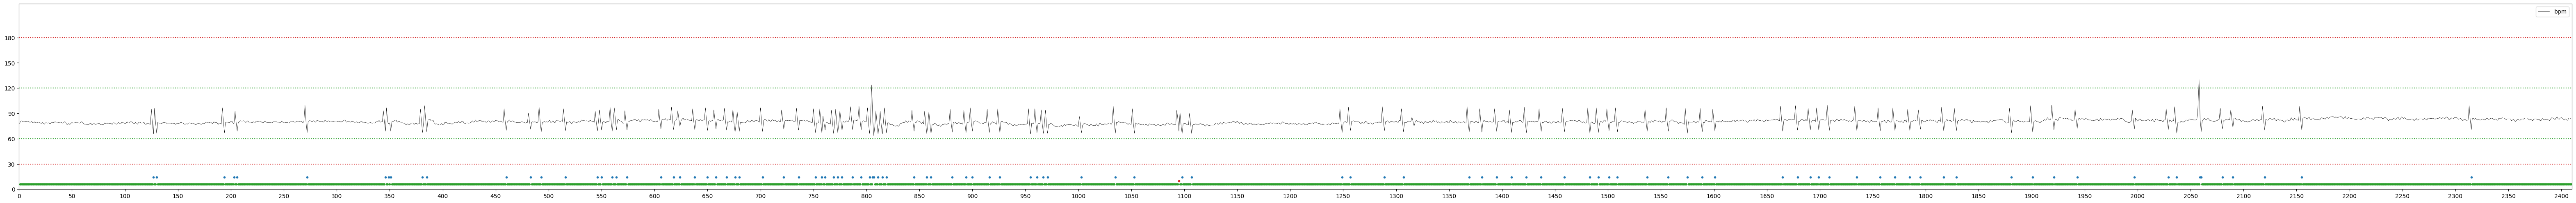

In [ ]:
print('#beats:',rpL)
plt.figure(figsize=(rpL/30,6), dpi=100)
plt.xlim((0,rpL))
plt.xticks(np.arange(0,rpL,50))
plt.ylim(10, 220)
plt.yticks(np.arange(0,210,30))

plt.hlines(30,0,rpL, linestyle='dotted',color='tab:red') #<-- 30bpm lower limit
plt.hlines(60,0,rpL, linestyle='dotted',color='tab:green') #<-- 
plt.hlines(120,0,rpL, linestyle='dotted',color='tab:green') #<-- 
plt.hlines(180,0,rpL, linestyle='dotted',color='tab:red') #<-- 180bpm lower limit

#ax[2].set_ylim((x,x))
bpmA = 60*BASIC_SRATE/rp_avg
plt.plot(bpmA , linewidth=0.5, color='black', label='bpm')
#filter = np.zeros(5)+(1/5)
#bpmS = np.convolve(bpmA, filter,mode='same')
#plt.plot(bpmS , linewidth=0.6, color='tab:blue', label='bpm')
#print(bpmA.shape,bpmS.shape)
plt.scatter(NR_any,np.zeros(len(NR_any))+6,color=custom_cols['_N'],marker='.') #marker=matplotlib.markers.TICKUP )
#plt.scatter(NA_list,np.zeros(len(NA_list))+12,color='white',marker='|') #marker=matplotlib.markers.TICKUP )
plt.scatter(NAS_list,np.zeros(len(NAS_list))+10,color=custom_cols['_S'],marker='.') #marker=matplotlib.markers.TICKUP )
plt.scatter(NAV_list,np.zeros(len(NAV_list))+14,color=custom_cols['_V'],marker='.') #marker=matplotlib.markers.TICKUP )
plt.scatter(NAF_list,np.zeros(len(NAF_list))+18,color=custom_cols['_F'],marker='.') #marker=matplotlib.markers.TICKUP )
plt.scatter(NAQ_list,np.zeros(len(NAQ_list))+22,color=custom_cols['_Q'],marker='.') #marker=matplotlib.markers.TICKUP )

#plt.scatter(NAV_list[1:-1],np.zeros(len(NAV_list)-2)+10,color=custom_cols['_V'],marker='s') #marker=matplotlib.markers.TICKUP )
#plt.scatter(NAF_list[1:-1],np.zeros(len(NAF_list)-2)+10,color=custom_cols['_F'],marker='s') #marker=matplotlib.markers.TICKUP )
#plt.scatter(NAQ_list[1:-1],np.zeros(len(NAQ_list)-2)+10,color=custom_cols['_Q'],marker='s') #marker=matplotlib.markers.TICKUP )

plt.legend()
plt.show()

## __> Plot Beat @ Fixed

12 52


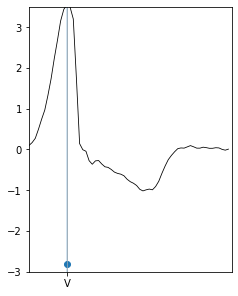

Label: ['_V']


In [ ]:
lsamp, rsamp = int(0.1*BASIC_SRATE),int(0.4*BASIC_SRATE)+1
print(lsamp, rsamp)

bindex = 811 #178
tpeak, tlabel=plot_api(rec,bindex,
         lsamp, rsamp ,
         show_label_ticks=True, show_custom_labels=True, show_custom_vline=True,w=0.05)
print('Label:',rec.mLabels[tlabel])

## __> Plot Beat @ var

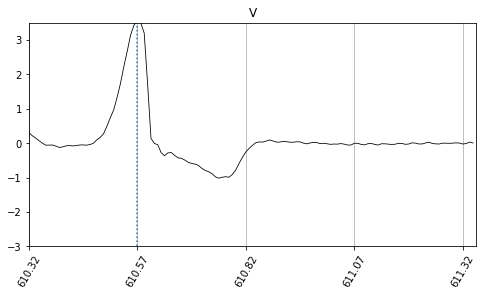

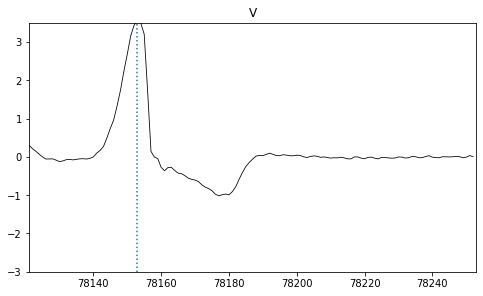

In [ ]:
mi,pi,spl,spr = 0,1,-32,32    # minus_i, plus_i ,signal_pad_left, signal_pad_right (in samples)
bindex = 811 

_=plot_beat(rec, bindex, mi, pi, spl, spr,w=0.05, h=4, r=0.25)
_=plot_beat(rec, bindex, mi, pi, spl, spr,w=0.05, h=4, r=0)

# [] ANALYZE DATA []

In [ ]:
#%% FOR TIME SERISE ANALYSIS

# <<---------------- define adf and kpss testing
def adf_test(timeseries, p_threshold , max_lags=None, details = False):
  res=""
  res += '\nADF-Test Hypothesis \t Series is Non-Stationary\n'
  dftest =  tsa.stattools.adfuller(timeseries,  regression='c', maxlag=max_lags, autolag=None )
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] =  (value, getHres(dftest[0],value) )

  if details:
    res+=str(dfoutput)+"\n"
  #if dftest[1]<p_threshold: # hypothesis is false = Rejected
  #if dftest[1]>p_threshold: # hypothesis is true = cannot reject
  resb =  (dftest[1]>=p_threshold)
  res+= "ADF-Test Result \t "+str( resb )
  
  return res, resb, dftest[1]

def getHres(test_stat, crit_val):
  if test_stat<crit_val:
    return "Hypothesis: False"
  else:
    return "Hypothesis: True"

#%%

# plot Autocorr and Partial Autocorr ------------------

def plotCF(Y, Lags, include_L0):
  fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
  plot_acf(Y,lags=Lags,zero=include_L0,ax=ax1)
  plot_pacf(Y,lags=Lags,zero=include_L0,ax=ax2)
  plt.show()
  
# TS analysis
def TSA(signal_slice, eo):
    
    data = pd.Series( (signal_slice))
    model_ARIMA = ARIMA(endog=signal_slice, order=eo)
    result_ARIMA = model_ARIMA.fit()
    return model_ARIMA, result_ARIMA
#%%

# <<----------------  define performace params

#3
def get_NSE(e,s):
  _e = np.mean(e)
  return 1 - ( np.sum((e-s)**2) / np.sum((e-_e)**2) )


#5
def get_CC(e,s):
  _e, _s = np.mean(e), np.mean(s)
  return np.sum((e-_e)*(s-_s)) / ((np.sum((e-_e)**2))**0.5 * (np.sum((s-_s)**2))**0.5)

#6
def get_r2(e,s):
  return get_CC(e,s)**2

#7
def get_MSE(e,s):
  N=len(e)
  return np.sum((e-s)**2)/N

#8
def get_RMSE(e,s):
  return get_MSE(e,s)**0.5
#%%
class ExpSmoothingData:
  def __init__(self, y):
    self.y = y
    self.N = len(y)

#~~~ SINGLE 0~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  def Do_Single_ES(self, a):
    N,y=self.N,self.y
    self.S = np.zeros(N,dtype='float')        #Smoothed Value  ::'0th element is invalid'
    S=self.S
    # initialization 
    S[0] = y[0] 
    # Find Smoothed values
    for t in range(1, N):
      S[t] = a*y[t] + (1-a)*S[t-1]

    # calculate the MSE
    MSE = (  np.sum( ( (y[1:]-S[1:])**2 )   )) / (N-1)

    # done
    return MSE, S
#~~~ DOUBLE 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  def Do_Double_ES(self, a, b): 
  # orignal Double ES
    N,y=self.N,self.y
    self.S = np.zeros(N).astype('float')        #Smoothed Value  ::'0th element is invalid'
    self.B = np.zeros(N).astype('float')          #b(t)
    B,S = self.B,self.S

    # initialization 
    S[0],B[0] = y[0], y[1] - y[0]

    # Find Smoothed values
    for t in range(1, N):
      S[t] = a*y[t] + (1-a)*(S[t-1]+B[t-1]) #<--- 1
      B[t] = b*(S[t]-S[t-1]) + (1-b)*B[t-1]

    # calculate the MSE
    MSE = (  np.sum( ( (y[1:]-S[1:])**2 )   )) / (N-1)

    # done
    return MSE, S

  def Do_Forecast_2(self, t, m):
    N,y=self.N,self.y
    S,B=self.S,self.B

    res = np.zeros(m)
    for i in range(1,m+1):
      res[i-1]=(S[t]+i*B[t])
    #res = (S[t]+m*B[t])#*I[t-L+m]

    return res

#%%

### Select Signal Slice

#### @Rpeak limit b/w consecutive peaks and trim ends

signal slice params: 0 1 -32 32
beat index = 220  @peak 21611  @TS 168.8359375  @Label N


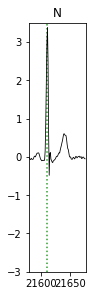

(98,)


In [ ]:
# uses this function
# def get_signal_slice_rri(self, Rpeaki, minus_i, plus_i ,signal_pad_left, signal_pad_right ): 
# return signal_slice, signal_list, pf, pt

# <<---------------- define signal slicing params here
mi,pi = 0,1     # minus_i, plus_i 
spl,spr = -32,32 # signal_pad_left, signal_pad_right (in samples)
print('signal slice params:',mi,pi,spl,spr)

# <<---------------- define beat index here
#blist = NAV_list
blist = NR_true
bindex = blist[random.randint(0, len(blist)-1) ] # 100
brpeak = rec.iRpeaks[bindex]
btimes = brpeak/BASIC_SRATE
blabel = rec.iLabels[bindex]
print('beat index =',bindex,
    ' @peak',   brpeak, 
    ' @TS',     btimes, 
    ' @Label',  blabel)

# <<---------------- get signal data here
signal, queryi, pf, pt  = plot_beat(rec, bindex, mi, pi, spl, spr,w=0.012, h=4, r=0 )  
  #plot_beat(rec, bindex, mi, pi, spl, spr,w=0.012, h=4, r=0.5):
print(signal.shape) 

#### @Rpeak fixed left and right samples

signal slice params: 12 52
beat index = 1089  @peak 81875  @TS 639.6484375  @Label N


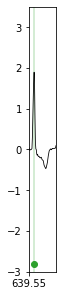

Done!


In [ ]:
# uses this function
#def get_signal_slice_api(self, Rpeaki, left_samples, right_samples ): :return signal_slice, iRpeak,
# return signal_slice, signal_list,

# <<---------------- define signal slicing params here
pl,pr = int(0.1*BASIC_SRATE),int(0.4*BASIC_SRATE)+1
print('signal slice params:',pl,pr)

# <<---------------- define beat index here
blist = NR_true
bindex = blist[random.randint(0, len(blist)-1) ] # 100
brpeak = rec.iRpeaks[bindex]
btimes = brpeak/BASIC_SRATE
blabel = rec.iLabels[bindex]
print('beat index =',bindex,
    ' @peak',   brpeak, 
    ' @TS',     btimes, 
    ' @Label',  blabel)

# <<---------------- get signal data here
signal, queryi = plot_api(rec, bindex, pl,pr, 
         show_label_ticks=False, show_custom_labels=True, show_custom_vline=True, w=0.012, h=4)

print('Done!')

#### @ fixed duration

signal slice params: 64000 65280


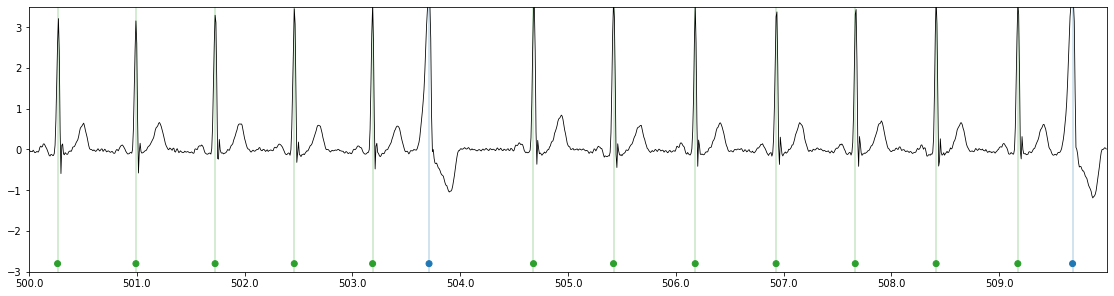

R-Peaks
 (14,) [64034 64127 64221 64315 64408 64475 64599 64694 64791 64887 64981 65077
 65174 65239]
R-Peaks
 [500.265625  500.9921875 501.7265625 502.4609375 503.1875    503.7109375
 504.6796875 505.421875  506.1796875 506.9296875 507.6640625 508.4140625
 509.171875  509.6796875]
RRI
 [ 93  94  94  93  67 124  95  97  96  94  96  97  65] 
 [0.7265625 0.734375  0.734375  0.7265625 0.5234375 0.96875   0.7421875
 0.7578125 0.75      0.734375  0.75      0.7578125 0.5078125]
Avg-RRI	 92.6923076923077 0.7241586538461539
bpm 82.85477178423237 84.0


In [ ]:
# uses this function
# def get_signal_slice_fd(self,pf, pt):return signal_slice, signal_list,
# return signal_slice, signal_list,

# <<---------------- define signal slicing params here
fbegin, fdelta = 500, 10 #sec
pl,pr = fbegin*BASIC_SRATE,(fbegin+fdelta)*BASIC_SRATE # pf, pt
print('signal slice params:',pl,pr)

# <<---------------- get signal data here
signal, queryi = plot_fixed(rec, pl, pr, mul_BSR=False,
                            show_label_ticks=False, show_custom_labels=True, show_custom_vline=True, w=0.012, h=4)
rrs = rec.iRpeaks[queryi]
print('R-Peaks\n',rrs.shape,rrs)
print('R-Peaks\n',rrs/BASIC_SRATE)
rri = rrs[1:]-rrs[0:-1] 
avgrri = np.average(rri)
print('RRI\n',rri,'\n',rri/BASIC_SRATE )
print('Avg-RRI\t',avgrri,avgrri/BASIC_SRATE )
bpm = 60*(BASIC_SRATE/avgrri)

bpm1 = (60*len(queryi)/fdelta)
print('bpm',bpm,bpm1)

### ADF Test, ACF, PACF


ADF-Test Hypothesis 	 Series is Non-Stationary
Test Statistic                                                 -2.62276
p-value                                                        0.088384
#Lags Used                                                           12
Number of Observations Used                                          85
Critical Value (1%)             (-3.5097356063504983, Hypothesis: True)
Critical Value (5%)             (-2.8961947486260944, Hypothesis: True)
Critical Value (10%)           (-2.5852576124567475, Hypothesis: False)
dtype: object
ADF-Test Result 	 True


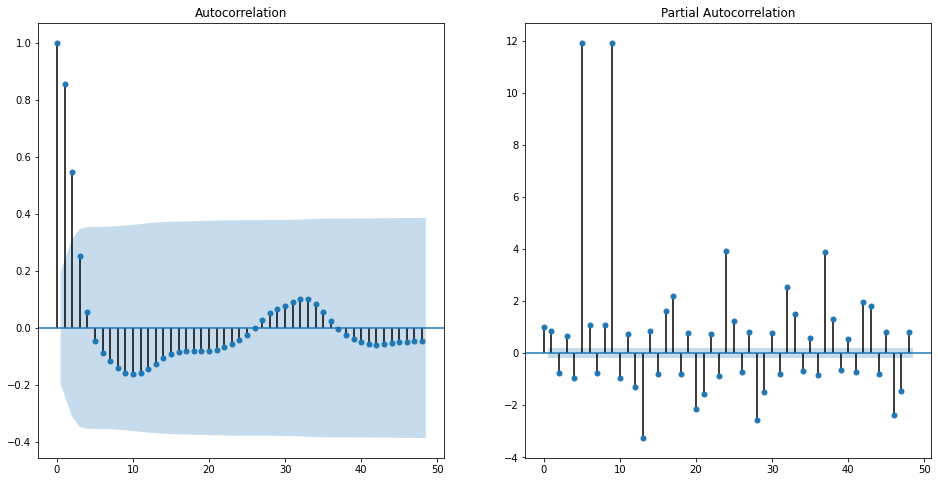


ADF-Test Hypothesis 	 Series is Non-Stationary
Test Statistic                                                 -3.63859
p-value                                                      0.00506472
#Lags Used                                                           12
Number of Observations Used                                          84
Critical Value (1%)             (-3.510711795769895, Hypothesis: False)
Critical Value (5%)            (-2.8966159448223734, Hypothesis: False)
Critical Value (10%)           (-2.5854823866213152, Hypothesis: False)
dtype: object
ADF-Test Result 	 False


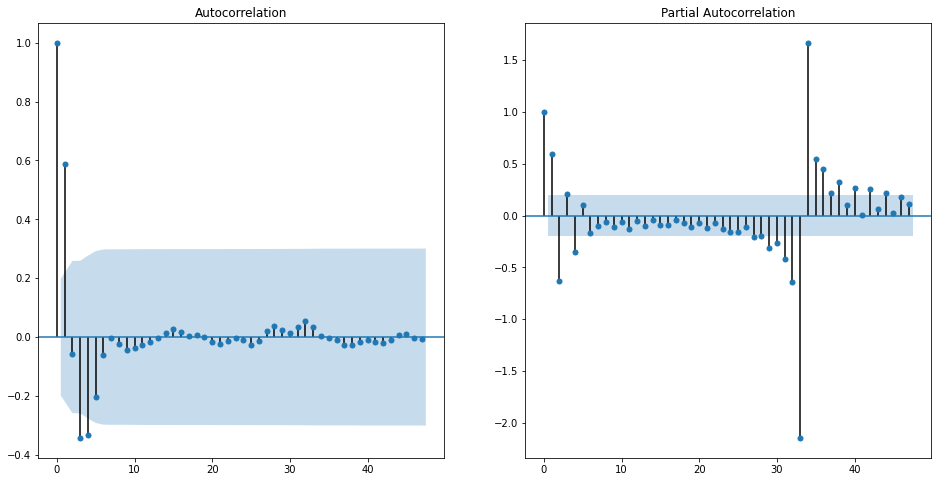

In [ ]:
# ADF Test
pval_thresh = 0.05
Ares, Aresb, Atest = adf_test(signal,pval_thresh, details=True)
print(Ares)

# plot ACF, PACF
Lags_CF = int(len(signal)/2)-1 #128*2 #int(len(signal)/2)-1
plotCF(signal, Lags_CF, True)

# diff
signal_diff = signal[1:] - signal[0:-1]
# ADF Test
pval_thresh = 0.05
Ares, Aresb, Atest = adf_test(signal_diff,pval_thresh, details=True)
print(Ares)

# plot ACF, PACF
Lags_CF = int(len(signal_diff)/2)-1 #128*2 #int(len(signal_diff)/2)-1
plotCF(signal_diff, Lags_CF, True)

### Exponential Smoothing

In [ ]:
# Exponential Smoothing
alpha, beta = 0.6, 0.3
es_data = ExpSmoothingData(signal)
mse,cast = es_data.Do_Double_ES(alpha, beta)
print('MSE =',mse)
plot_beat(rec, cast, bindex, mi, pi, spl, spr,w=0.1, h=6, r=0, pshift=0,dpi=150, hide_data=False)

# ADF Test
pval_thresh = 0.05
Ares, Aresb, Atest = adf_test(cast,pval_thresh,details=False)
print(Ares)

# plot ACF, PACF
Lags_CF = int(len(cast)/2)-1
plotCF(cast, Lags_CF, True)

### ARIMA

Dependence period = 6

ARIMA PARAMS: 8 
 ['const', 'ar.L1', 'ar.L2', 'ar.L3', 'ar.L4', 'ar.L5', 'ar.L6', 'sigma2'] 
 [ 0.13459035  1.97059242 -1.96911068  1.28520646 -0.60522439  0.21534777
 -0.06465189  0.02430425]


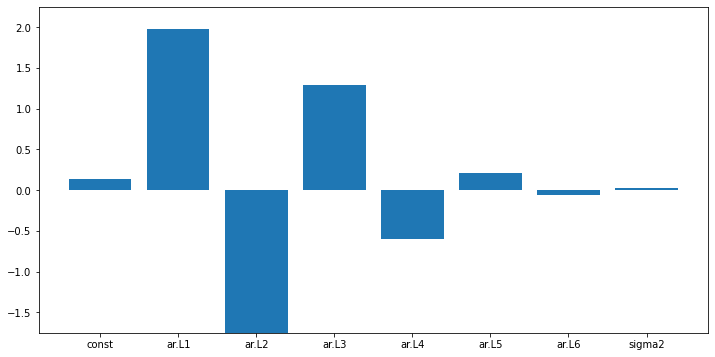



MSE = 0.05307543011393821 	(p,d,q) = (6, 0, 0)


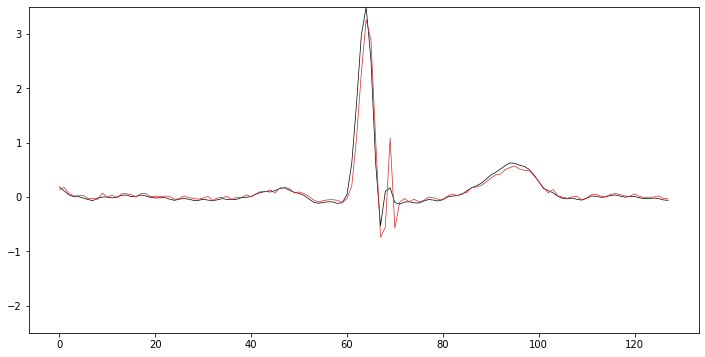

In [ ]:
dep_period = 6 #int(0.12 * BASIC_SRATE)
print('Dependence period =',dep_period)
ARIMA_PARAM = (dep_period,0,0) #(p,d,q)

sel_sig = signal  # signal cast
# fit ARIMA
model_ARIMA, result_ARIMA = TSA(sel_sig, ARIMA_PARAM)
print('\nARIMA PARAMS:',len(result_ARIMA.params),'\n',result_ARIMA.param_names,'\n', result_ARIMA.params)
pred_ts = result_ARIMA.predict()

plt.figure(figsize=(12,6))
plt.bar(result_ARIMA.param_names,result_ARIMA.params)
plt.ylim(-1.75,2.25)
plt.show()
#print(pred_ts.shape, sel_sig.shape)
assert (pred_ts.shape == sel_sig.shape)
MSE=get_MSE(sel_sig[0:-1],pred_ts[1:])
print('\n\nMSE =',MSE, '\t(p,d,q) =',ARIMA_PARAM,)

# plot 
plt.figure(figsize=(12,6))
plt.ylim(-2.5,3.5)
plt.plot(signal, linewidth=0.7, label='data', color='black')
plt.plot(pred_ts, linewidth=0.7, label='cast', color='tab:red')



---

# [] _______ []

---



# [_] ARCHIVE [_]

In [ ]:
#apply AIC criteria to ARIMA?
#Autoencoder for anamoly detection?

for ecgDatabase
self.dbname = arg_dbname
self.dbpath = os.path.join(global_dir, self.dbname + '_npy' )
self.record_list = np.loadtxt(os.path.join(self.dbpath,'RECORDS'), dtype='str',delimiter="\n")
self.records = {}
def get_record(self, rec_name):

for ecgRecord
self.db = arg_parent_db # ecgDatabase object
self.name = arg_recname
self.isloaded = False
self.signal_file = os.path.join(self.db.dbpath,self.name + g_SIG2)
self.iSignal = np.load(self.signal_file)
self.beat_file = os.path.join(self.db.dbpath,self.name + g_BEAT)
self.iBeat = np.load(self.beat_file)
self.iRpeaks = self.iBeat[:,0].astype('int') #<<-- convert sampling locations to integer
self.iLabels = self.iBeat[:,1]               #<<-- labels remain as string
self.nos_beats = len(self.iRpeaks)
def get_signal_slice_rri(self, Rpeaki, minus_i, plus_i, crop_left, crop_right): return signal_slice
def get_signal_slice_fd(self,plot_from, plot_to): return self.iSignal[pf:pt], query_list
def get_signal_slice_ap(self, Rpeak, left_duration, right_duration ): return signal_slice, beat_list
def get_signal_slice_api(self, Rpeaki, left_duration, right_duration ): return signal_slice
def get_beats_of_label(self, self_label_list, lable_to_find, time_from, time_to): return a_list
def get_all_beats_of_label(self, self_label_list, lable_to_find):  return a_list
def map_beat_labels(self, aami_mapping): return iLabels